In [2]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/rainorangelemon/Documents/tiny-diffusion


/home/rainorangelemon/micromamba/envs/sam2/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from hydra import initialize, compose
from utils_clevr import CLEVRPosDataset
from hydra.core.global_hydra import GlobalHydra
GlobalHydra.instance().clear()

with initialize(config_path="../conf", version_base="1.1"):
    cfg = compose(config_name="clevr_pos",
                  overrides=["num_constraints=5",
                             # "ckpt_path=ComposableDiff/models/ema_runpod_780000.pt",
                             # "model.noise_schedule=linear",
                            ])

dataset = CLEVRPosDataset(data_path=cfg.data_path)

/home/rainorangelemon/Documents/tiny-diffusion/scripts/best_of_n_on_sam_dataset.py:480: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="../conf")
/home/rainorangelemon/micromamba/envs/sam2/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'clevr_pos': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [4]:
%cd ../sam2

/home/rainorangelemon/Documents/sam2


/home/rainorangelemon/micromamba/envs/sam2/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from hydra.core.global_hydra import GlobalHydra
GlobalHydra.instance().clear()

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )


np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    # label the points with the index
    for i, (x, y) in enumerate(coords):
        ax.text(x, y, str(i), fontsize=12, color='white', ha='center', va='center')

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()


from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)
mask_generator = SAM2AutomaticMaskGenerator(sam2)

using device: cuda


In [6]:
# def classification_with_sam(image, input_points):
#     img_batch = [image] * len(input_points)
#     predictor.set_image_batch(img_batch)

#     input_points = np.array(input_points)
#     input_points[:, 0] = input_points[:, 0] * len(image)
#     input_points[:, 1] = (1 - input_points[:, 1]) * len(image[0])
#     input_labels = np.array([1] * len(input_points))
#     draw_labels =  np.array([1] * len(input_points))

#     masks_batch, _, _ = predictor.predict_batch(
#         point_coords_batch=[p[np.newaxis] for p in input_points],
#         point_labels_batch=[l[np.newaxis] for l in input_labels],
#         multimask_output=True,
#     )

#     success = True
#     for i, masks in zip(range(len(input_points)), masks_batch):

#         success_per_point = ((masks.sum(axis=(1, 2)) > 100) & (masks.sum(axis=(1, 2)) < 1000)).any()
#         success = success and success_per_point

#         if not success_per_point:
#             draw_labels[i] = 0

#     return success, masks_batch, draw_labels


def classification_with_sam(image, input_points):
    anns = mask_generator.generate(image)

    input_points = np.array(input_points)
    input_points[:, 0] = input_points[:, 0] * len(image)
    input_points[:, 1] = (1 - input_points[:, 1]) * len(image[0])
    input_labels = np.array([1] * len(input_points))
    draw_labels =  np.array([1] * len(input_points))

    # get the background mask which has the largest area
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    background_mask = sorted_anns[0]['segmentation']

    success = True
    for i in range(len(input_points)):

        # check if the point is inside the background mask
        point = input_points[i]
        success_per_point = (background_mask[int(point[1]), int(point[0])] == 0)
        success = success and success_per_point

        if not success_per_point:
            draw_labels[i] = 0

    return success, background_mask, draw_labels

# Classify the notebook figures

In [6]:
import glob
from tqdm.auto import tqdm

successes = []
for condition_idx in range(10):
    success_per_condition = []
    for sample_idx in tqdm(range(100)):
        coords, _ = dataset[condition_idx]
        # img_path = f"../tiny-diffusion/runs/10-30_12-00-51_clevr_pos_5_notebook-logp/test_clevr_pos_5000_5/individual_sample_{condition_idx:05d}_{sample_idx}.png"
        img_path = f"../tiny-diffusion/runs/11-04_10-02-02_clevr_pos_5_notebook-logp/test_clevr_pos_5000_5/individual_sample_{condition_idx:05d}_{sample_idx}.png"
        img = Image.open(img_path)
        img = np.array(img)
        success, _, draw_labels = classification_with_sam(img, coords)
        # plt.close('all')
        # plt.clf()
        # plt.figure(figsize=(10, 10))
        # plt.imshow(img)
        # coords = coords.copy()
        # coords[:, 0] = coords[:, 0] * len(img)
        # coords[:, 1] = (1 - coords[:, 1]) * len(img[0])
        # show_points(coords, draw_labels, plt.gca())
        # plt.savefig(f"../tiny-diffusion/runs/10-30_12-00-51_clevr_pos_5_notebook-logp/sam_labels/{condition_idx:05d}_{sample_idx}.png")

        success_per_condition.append(success)
    successes.append(success_per_condition)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
# save the results
np.save("../tiny-diffusion/runs/11-04_10-02-02_clevr_pos_5_notebook-logp/sam_labels/successes.npy", successes)

# Classify the bash script figures

In [6]:
import glob
from tqdm.auto import tqdm

successes = []
for condition_idx in tqdm(range(5000)):
    coords, _ = dataset[condition_idx]
    img_path = f"../tiny-diffusion/runs/rejection_clevr_pos_5/test_clevr_pos_5000_5/sample_{condition_idx:05d}.png"
    img = Image.open(img_path)
    img = np.array(img)
    success, _, draw_labels = classification_with_sam(img, coords)
    successes.append(success)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [15]:
packed_energies = torch.load("../tiny-diffusion/runs/rejection_clevr_pos_5/test_clevr_pos_5000_5/packed_energies.pt")
np.array(successes)[~(packed_energies > 0).any(dim=1).all(dim=1)].mean()

np.float64(0.9545004945598418)

In [7]:
np.array(successes).mean()

np.float64(0.9026)

In [ ]:
# np.save("../tiny-diffusion/runs/11-05_14-52-32_clevr_pos_5_notebook-logp/test_clevr_pos_5000_5/sam_labels.npy", successes)
np.save("../tiny-diffusion/runs/rejection_clevr_pos_5/test_clevr_pos_5000_5/sam_labels.npy", successes)

# One Single Example

In [7]:
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        break
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

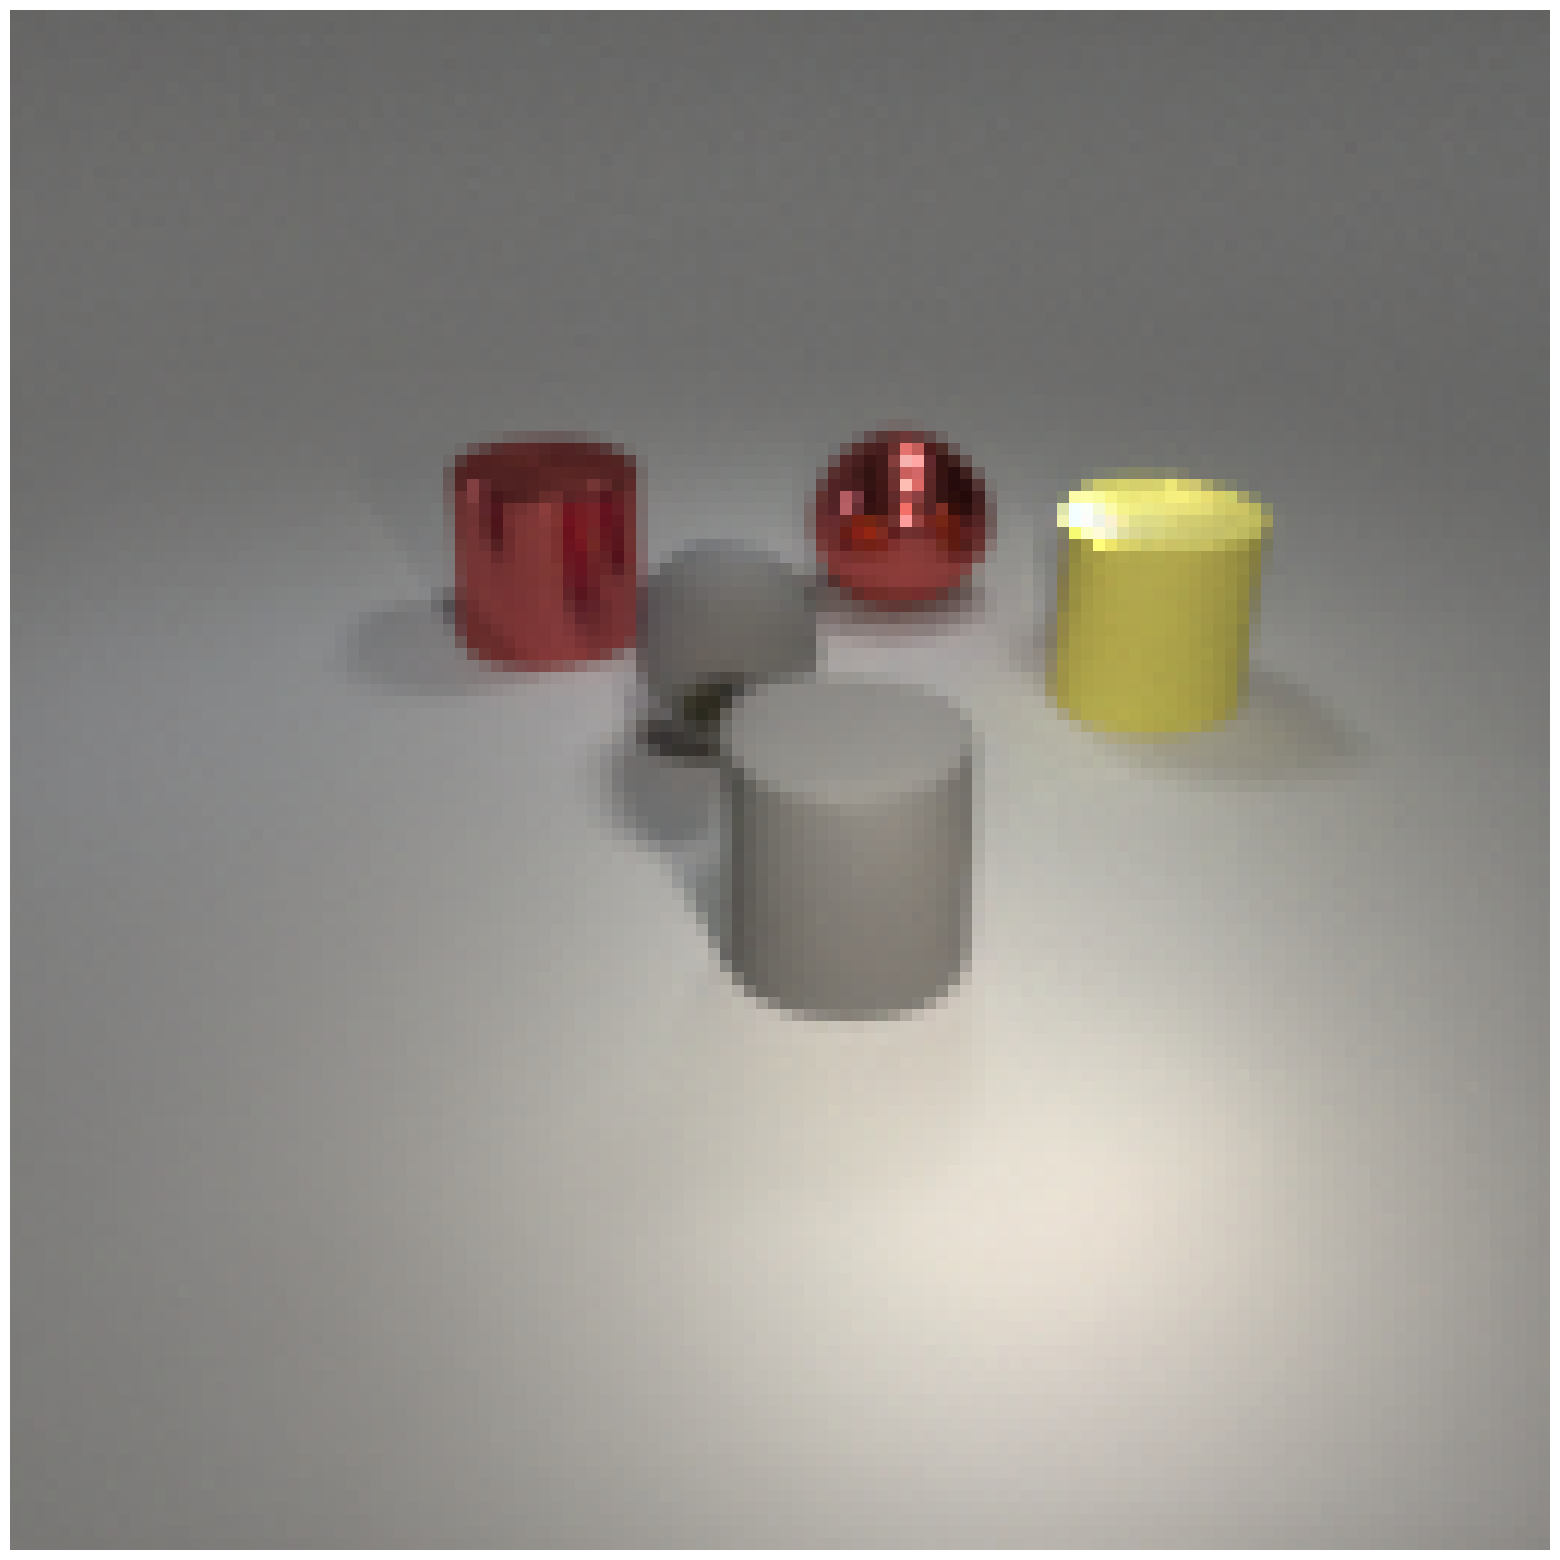

In [8]:
img_path = f"../tiny-diffusion/runs/rejection_clevr_pos_5/test_clevr_pos_5000_5/sample_00000.png"
img = Image.open(img_path)
img = np.array(img)
masks = mask_generator.generate(img)
plt.figure(figsize=(20, 20))
plt.imshow(img)
show_anns(masks)
plt.axis('off')
plt.show()

In [9]:
success, _, draw_labels = classification_with_sam(img, dataset[0][0])

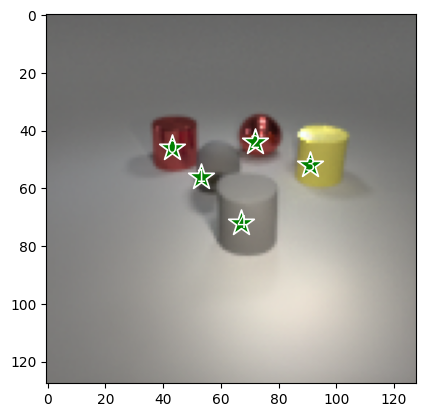

In [12]:
# draw the labels
plt.clf()
plt.imshow(img)
coord = dataset[0][0].copy()
input_points = np.array(coord)
input_points[:, 0] = input_points[:, 0] * len(img)
input_points[:, 1] = (1 - input_points[:, 1]) * len(img[0])
show_points(input_points, draw_labels, plt.gca())